In [1]:
import pandas as pd

import numpy as np

np.random.seed(0)

import torch

torch.manual_seed(0)
torch.set_default_dtype(torch.double)

import gpytorch

import sys

sys.path.append("../")

from utils.constants import CATS, ANS, FEATURES, TARGET_NOISE, TARGET

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "Blues"
plt.rcParams["image.cmap"] = "magma"

from tqdm import tqdm

# training

In [2]:
cols = CATS + ANS + FEATURES + [TARGET_NOISE, TARGET]
num_dims = len(CATS) + len(ANS)

df = pd.read_csv("../data/free_energies_031522.csv")[cols]
df

,Pb,Sn,Ge,Te,Se,S,var_vol_norm,Uncertainty (meV/fu),Hmix_unk (meV/fu)
0,0.333333,0.333333,0.333333,0.000000,0.500000,0.500000,0.009763,1.471047,27.352267
1,0.000000,1.000000,0.000000,0.500000,0.500000,0.000000,0.006110,1.035332,28.269825
2,1.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.016794,1.770743,72.108514
3,1.000000,0.000000,0.000000,0.000000,0.250000,0.750000,0.001836,0.315186,12.684210
4,1.000000,0.000000,0.000000,0.166667,0.416667,0.416667,0.008908,1.530357,42.614178
...,...,...,...,...,...,...,...,...,...
57,1.000000,0.000000,0.000000,0.416667,0.583333,0.000000,0.006690,1.144657,32.063310
58,1.000000,0.000000,0.000000,0.750000,0.000000,0.250000,0.011109,1.264009,53.882966
59,0.000000,0.500000,0.500000,0.500000,0.500000,0.000000,0.010844,1.344624,27.725366
60,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.007639,1.098837,35.349947


In [3]:
train_x = df[cols[:-2]].values
train_x = torch.tensor(train_x).double()
train_x.shape

torch.Size([62, 7])

In [4]:
noise_train = df[cols[-2]].values
noise_train = torch.tensor(noise_train)

print(noise_train.shape)
noise_train

torch.Size([62])


tensor([1.4710, 1.0353, 1.7707, 0.3152, 1.5304, 3.2570, 0.4510, 1.8592, 1.7219,
        0.8856, 2.7601, 1.4802, 0.5052, 1.6419, 2.4526, 1.5393, 1.2662, 0.7511,
        1.0137, 0.5045, 0.4138, 0.7215, 2.7426, 1.6263, 1.6330, 1.9146, 1.4154,
        0.6421, 0.3120, 1.2501, 0.8812, 1.5924, 2.7483, 0.8012, 0.4766, 0.3574,
        1.3297, 1.8167, 2.5327, 1.7757, 1.8324, 0.9836, 0.5459, 1.3685, 1.6970,
        0.3777, 0.9773, 1.4641, 1.1091, 0.9099, 0.3566, 1.1297, 1.4718, 1.2409,
        1.4151, 0.2989, 1.0383, 1.1447, 1.2640, 1.3446, 1.0988, 1.1203])

In [5]:
train_y = df[cols[-1]].values
train_y = torch.tensor(train_y)

print(train_y.shape)
train_y

torch.Size([62])


tensor([27.3523, 28.2698, 72.1085, 12.6842, 42.6142, 67.8133, 21.5816, 55.2244,
        13.6712, 20.4176, 50.0982, 68.0026, 16.7280, 51.9734, 64.8887, 53.1392,
        51.2300, 29.3930, 30.5236, 31.9337, 24.5937, 26.4572, 71.3687, 33.8535,
        22.6855, 50.9555, 14.2838, 19.4479, 10.7675, 42.3587, 30.1645, 64.5458,
        18.7507, 53.0615, 15.4001, 13.1188, 44.1381, 54.2661, 60.9516, 39.5588,
        68.1867, 28.5455, 17.8176, 43.8663, 44.8055, 10.7905, 24.9268, 15.4667,
        27.0121, 24.6133, 11.6748, 44.8381, 32.7722, 44.4999, 63.1889, 12.2962,
        32.6980, 32.0633, 53.8830, 27.7254, 35.3499, 32.5330])

In [6]:
class CustomLinearMean(gpytorch.means.Mean):
    def __init__(self, batch_shape=torch.Size()):
        super().__init__()

        self.register_parameter(
            "weight", parameter=torch.nn.Parameter(torch.randn(len(FEATURES)))
        )
        self.register_parameter(
            "bias", parameter=torch.nn.Parameter(torch.randn(len(FEATURES)))
        )

    def forward(self, x):
        return torch.matmul(x[:, num_dims:], self.weight) + self.bias


class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = CustomLinearMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=num_dims)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x[:, num_dims:])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    noise=noise_train**2, learn_additional_noise=True
)

model = GPModel(train_x, train_y, likelihood)

In [8]:
(
    model.mean_module.weight.item(),
    model.mean_module.bias.item(),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.detach().numpy(),
)

(1.5409961082440433,
 -0.2934289057609464,
 0.6931471805599453,
 array([[0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
         0.69314718]]))

100%|██████████| 1000/1000 [00:02<00:00, 481.09it/s]


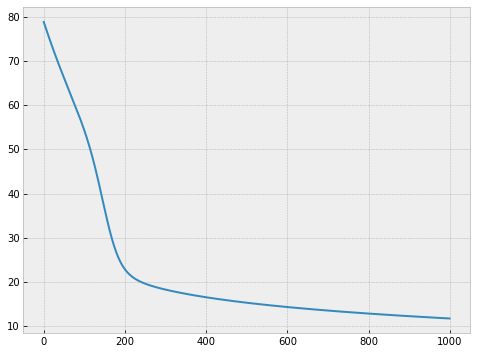

In [9]:
num_iters = 1000

# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
for i in tqdm(range(num_iters)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

model.eval()
likelihood.eval()

plt.figure(figsize=(8, 6))
plt.plot(losses);

In [10]:
(
    model.mean_module.weight.item(),
    model.mean_module.bias.item(),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.detach().numpy(),
)

(5.590722767054979,
 6.745437091009311,
 5.375583314900673,
 array([[0.02964128, 0.02964128, 0.02964128, 0.02964128, 0.02964128,
         0.02964128]]))

# inference

In [11]:
from utils.plotting import plot_regressor_square_edges

In [12]:
test_cols = CATS + ANS + FEATURES
space_df = pd.read_csv("../data/space_w_feats.csv")[test_cols]

test_x = torch.tensor(space_df.values).double()
test_x.shape

torch.Size([3481, 7])

0
SnSe – PbSe
tensor([[0.5000, 0.5000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0011]])
tensor([10.7675])
1
SnSe – SnTe
tensor([[0.0000, 1.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0061]])
tensor([28.2698])
2
SnTe – PbTe
tensor([[0.5000, 0.5000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0013]])
tensor([10.7905])
3
PbSe – PbTe
tensor([[1.0000, 0.0000, 0.0000, 0.1667, 0.8333, 0.0000, 0.0042],
        [1.0000, 0.0000, 0.0000, 0.8333, 0.1667, 0.0000, 0.0033],
        [1.0000, 0.0000, 0.0000, 0.5833, 0.4167, 0.0000, 0.0063],
        [1.0000, 0.0000, 0.0000, 0.0833, 0.9167, 0.0000, 0.0024],
        [1.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.0063],
        [1.0000, 0.0000, 0.0000, 0.2500, 0.7500, 0.0000, 0.0055],
        [1.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.0000, 0.0056],
        [1.0000, 0.0000, 0.0000, 0.7500, 0.2500, 0.0000, 0.0046],
        [1.0000, 0.0000, 0.0000, 0.9167, 0.0833, 0.0000, 0.0018],
        [1.0000, 0.0000, 0.0000, 0.4167, 0.5833, 0.0000, 0.0067],
        [1.0000, 0.0000, 0.00

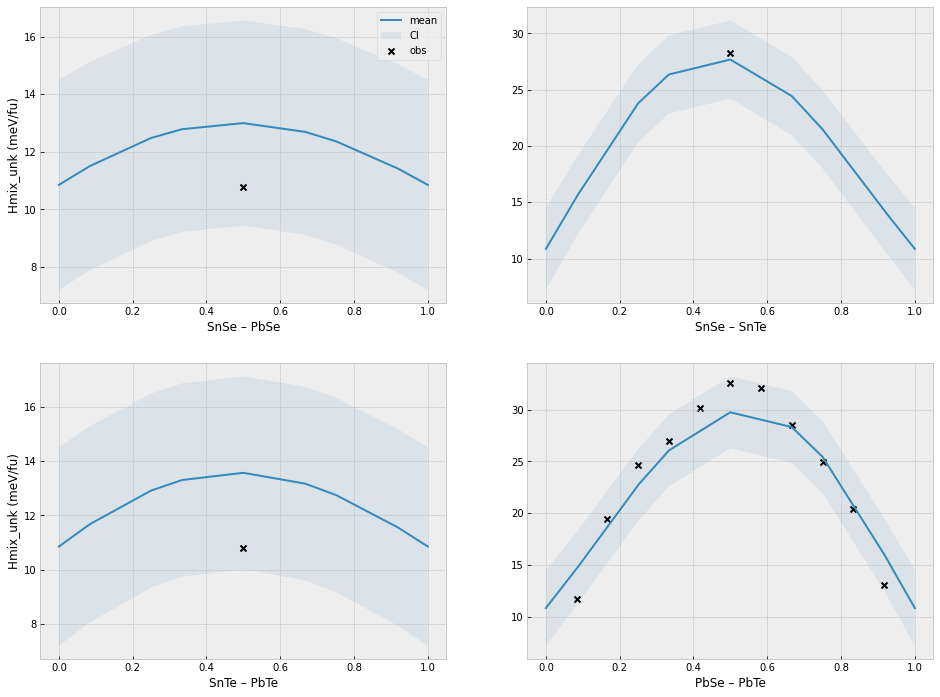

In [13]:
cat_ind1 = 0
cat_ind2 = 1

an_ind1 = 3
an_ind2 = 4

plot_regressor_square_edges(
    cat_ind1,
    cat_ind2,
    an_ind1,
    an_ind2,
    model,
    likelihood,
    train_x,
    train_y,
    test_x
)